In [36]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

#for getting summery info of the model
from torchsummary import summary

import matplotlib.pyplot as plt

# Import and process the data

In [37]:
data = np.loadtxt(open(r"C:\Users\knock\Downloads\mnist_train_small.csv",'rb'),delimiter=',')

label = data[:,0]
data = data[:,1:]

data_norm = data/np.max(data)
#reshape to 2D data
data_norm = data_norm.reshape(data_norm.shape[0],1,28,28)

In [38]:
data_norm.shape

(20000, 1, 28, 28)

# Create train/test groups using dataloader

In [39]:
#estep 1: convert to tensor
data_t = torch.tensor(data_norm).float()
label_t = torch.tensor(label).long()

#step:2 use cklearn train split to get train and test datas
X_train, X_test, y_train, y_test = train_test_split(data_t, label_t, test_size=0.10, random_state=42)

#step 3: creating tesor datset
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

#step4: Translate into dataloader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [40]:
#check size (should be images X channels X width X height)
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

# Create a DL model

In [41]:
# Create a class for the model
def create_mnist_net(printtoggle=False):

    class mnist_net(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ###convolution layer
            self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1,padding=1)
            #size: np.floor(   (28+2*1-5)/1 )+1 = 26/2 = 13(/2 b/c maxpool)
            self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            #size: np.floor(   (13+2*1-5)/1 )+1 = 13/2 = 5(/2 b/c maxpool)

            #compute the number of units in FCayer(numbers of output of COnv2)
            expectsize = np.floor(  (5+2*0-1)/1)+1 # Fc1 has no layer no padding kernel so
            expectsize = 20*int(expectsize**2)  #same h,w

            ### fully connected layer
            self.fc1 = nn.Linear(expectsize,50)

            ###output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out the tensor size the forward prop
            self.print = printtoggle

        #forward pass
        def forward(self,x):

            print(f"Input: {x.shape}") if self.print else None

            #convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x),2))   #size of pool window/pool kernel (2 by 2 square here)
            print(f"Layer conv1/pool1: {x.shape}") if self.print else None

            #and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x),2))
            print(f"Layer conv2/pool2: {x.shape}") if self.print else None

            #reshape for linear layer
            n_units = x.shape.numel()/x.shape[0]
            print(x.shape.numel(),n_units) if self.print else None
            x = x.view(-1,int(n_units))
            # print("X",x)
            # print(x.shape)
            # print(f"x.view(-1) :{x.view(-1,int(n_units))}") if self.print else None
            if self.print: print(f"Vectorize: {x.shape}")

            #lineaer layer
            x = F.relu( self.fc1(x) )
            if self.print: print(f"Layer fc1: {x.shape}")
            x = self.out(x)
            if self.print: print(f"Layer out: {x.shape}")


            return x
    #create a class instance
    net = mnist_net(printtoggle)

    #loss function
    loss_fun = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam( net.parameters(), lr=.01)

    return net,loss_fun,optimizer

In [42]:
# test model with one batch
net, lossfun, optimizer = create_mnist_net(True)
X,y = iter(train_loader).next()
y_hat = net(X)

#check the sizes of the model
print(" ")
print(y_hat.shape)
print(y.shape)

#now let's compute the loss
loss = lossfun(y_hat,y)
print(" ")
print("loss")
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
16000 500.0
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
loss
tensor(2.3011, grad_fn=<NllLossBackward0>)


In [43]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Train the model

In [44]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = create_mnist_net()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model and show the results!

In [45]:
trainAcc,testAcc,losses,net = function2trainTheModel()

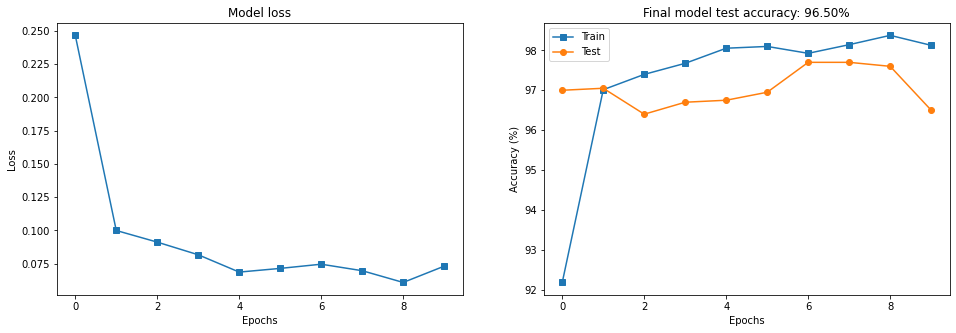

In [46]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()